In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Utility functions
def print_size_of_model(model, name="Model"):
    """Prints the real size of the model"""
    torch.save(model.state_dict(), "temp.p")
    print(f'Size of {name} (MB): {os.path.getsize("temp.p") / 1e6}')
    os.remove('temp.p')

# Define LeNet5V1 Model
class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28x28->32x32->28x28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14x14

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10x10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

# Train function
def train(model, dataloader, cuda=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model.train()
    for epoch in range(10):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if i % 100 == 0:
                print(f'Epoch [{epoch + 1}], Step [{i}], Loss: {running_loss / (i + 1):.4f}, Accuracy: {100 * correct / total:.2f}%')

    print('Finished Training')

# Test function
def test(model, dataloader, cuda=False):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model: {accuracy}%')
    return accuracy

# Train and test FP32 model
net_fp32 = LeNet5V1().cuda()
print_size_of_model(net_fp32, "FP32 Model")
train(net_fp32, trainloader, cuda=True)
score_fp32 = test(net_fp32, testloader, cuda=True)
print(f'FP32 Model Accuracy: {score_fp32}%')


Using device: cuda
Size of FP32 Model (MB): 0.250446
Epoch [1], Step [0], Loss: 2.3137, Accuracy: 10.94%
Epoch [1], Step [100], Loss: 2.2874, Accuracy: 13.24%
Epoch [1], Step [200], Loss: 2.2600, Accuracy: 16.11%
Epoch [1], Step [300], Loss: 2.2174, Accuracy: 23.50%
Epoch [1], Step [400], Loss: 2.1389, Accuracy: 31.51%
Epoch [1], Step [500], Loss: 2.0205, Accuracy: 37.22%
Epoch [1], Step [600], Loss: 1.8869, Accuracy: 42.35%
Epoch [1], Step [700], Loss: 1.7610, Accuracy: 46.95%
Epoch [1], Step [800], Loss: 1.6446, Accuracy: 51.10%
Epoch [1], Step [900], Loss: 1.5402, Accuracy: 54.69%
Epoch [2], Step [0], Loss: 0.5825, Accuracy: 85.94%
Epoch [2], Step [100], Loss: 0.6107, Accuracy: 85.12%
Epoch [2], Step [200], Loss: 0.5854, Accuracy: 85.57%
Epoch [2], Step [300], Loss: 0.5608, Accuracy: 85.99%
Epoch [2], Step [400], Loss: 0.5432, Accuracy: 86.35%
Epoch [2], Step [500], Loss: 0.5281, Accuracy: 86.55%
Epoch [2], Step [600], Loss: 0.5154, Accuracy: 86.76%
Epoch [2], Step [700], Loss: 0.50

In [2]:
import torch.nn.functional as F

# General quantization and dequantization with variable precision
def quantize(tensor, precision):
    """Quantize tensor to the given precision."""
    max_val = 2 ** (precision - 1) - 1  # Calculate the max representable value based on precision
    scale = max_val / tensor.abs().max()  # Scale factor to map to the given precision range
    quantized_tensor = (tensor * scale).clamp(-max_val, max_val).round().to(torch.int8 if precision <= 8 else torch.int32)  # Quantize
    return quantized_tensor, scale

def dequantize(quantized_tensor, scale):
    """Dequantize tensor back to float."""
    return quantized_tensor.float() / scale  # Dequantize back to float

# Quantized forward pass with variable precision
def quantized_forward_with_input_quant_lenet5v1(model, x, precision=8):
    with torch.no_grad():
        # Quantize the input
        x_q, input_scale = quantize(x, precision)  # Quantize input with the provided precision

        # Manually quantizing each layer's weights (skip non-weighted layers like Tanh and pooling)
        conv1_w_q, conv1_scale = quantize(model.feature[0].weight.data, precision)  # Conv2d layer
        conv2_w_q, conv2_scale = quantize(model.feature[3].weight.data, precision)  # Conv2d layer

        # Forward pass with dequantized weights
        x = F.conv2d(dequantize(x_q, input_scale), dequantize(conv1_w_q, conv1_scale), stride=1, padding=2)
        x = model.feature[1](x)  # Tanh (no weights)
        x = model.feature[2](x)  # AvgPool2d (no weights)

        x_q, input_scale = quantize(x, precision)  # Re-quantize the intermediate activation

        x = F.conv2d(dequantize(x_q, input_scale), dequantize(conv2_w_q, conv2_scale), stride=1)
        x = model.feature[4](x)  # Tanh (no weights)
        x = model.feature[5](x)  # AvgPool2d (no weights)

        x = x.view(x.size(0), -1)  # Flatten the tensor correctly

        # Dequantize and apply the fully connected layers
        fc1_w_q, fc1_scale = quantize(model.classifier[1].weight.data, precision)  # Linear layer
        fc2_w_q, fc2_scale = quantize(model.classifier[3].weight.data, precision)  # Linear layer
        fc3_w_q, fc3_scale = quantize(model.classifier[5].weight.data, precision)  # Linear layer

        x_q, input_scale = quantize(x, precision)  # Quantize the flattened output before fully connected layers

        x = F.linear(dequantize(x_q, input_scale), dequantize(fc1_w_q, fc1_scale))  # Linear layer
        x = model.classifier[2](x)  # Tanh (no weights)

        x_q, input_scale = quantize(x, precision)  # Re-quantize before the next layer

        x = F.linear(dequantize(x_q, input_scale), dequantize(fc2_w_q, fc2_scale))  # Linear layer
        x = model.classifier[4](x)  # Tanh (no weights)

        x_q, input_scale = quantize(x, precision)  # Re-quantize before the final layer

        x = F.linear(dequantize(x_q, input_scale), dequantize(fc3_w_q, fc3_scale))  # Linear layer

    return x

# Quantized model testing function with variable precision
def test_quantized_with_input_quant_lenet5v1(model, dataloader, precision=8, cuda=False):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = quantized_forward_with_input_quant_lenet5v1(model, inputs, precision)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the quantized model ({precision}-bit) with input quantization on the test images: {accuracy}%')
    return accuracy

# Test the model with variable precision
precision = 4  # You can change this to test different precisions, e.g., 4, 16, etc.
print(f"Testing Quantized Model with {precision}-bit Precision...")
score_quantized = test_quantized_with_input_quant_lenet5v1(net_fp32, testloader, precision=precision, cuda=True)

# Print model accuracies for comparison
print(f'{precision}-bit Quantized Model Accuracy: {score_quantized}%')


Testing Quantized Model with 4-bit Precision...
Accuracy of the quantized model (4-bit) with input quantization on the test images: 95.64%
4-bit Quantized Model Accuracy: 95.64%


In [8]:
import qtorch_plus
from qtorch_plus.quant import posit_quantize

# Correct posit quantization for the LeNet5V1 model
def quantized_forward_posit_with_input_quant_lenet5v1(model, x, nsize=8, es=0):
    with torch.no_grad():
        # Quantize the input
        x_q = posit_quantize(x, nsize=nsize, es=es)  # Quantize input

        # Manually quantizing each layer's weights (skip non-weighted layers like Tanh and pooling)
        conv1_w_q = posit_quantize(model.feature[0].weight.data, nsize=nsize, es=es)  # Conv2d layer
        conv2_w_q = posit_quantize(model.feature[3].weight.data, nsize=nsize, es=es)  # Conv2d layer (note index 3, not 4)

        # Forward pass with quantized weights
        x = F.conv2d(x_q, conv1_w_q, stride=1, padding=2)
        x = model.feature[1](x)  # Tanh (no weights)
        x = model.feature[2](x)  # AvgPool2d (no weights)

        x_q = posit_quantize(x, nsize=nsize, es=es)  # Re-quantize the intermediate activation

        x = F.conv2d(x_q, conv2_w_q, stride=1)
        x = model.feature[4](x)  # Tanh (no weights)
        x = model.feature[5](x)  # AvgPool2d (no weights)

        x = x.view(x.size(0), -1)  # Flatten the tensor correctly

        # Quantize and apply the fully connected layers
        fc1_w_q = posit_quantize(model.classifier[1].weight.data, nsize=nsize, es=es)  # Linear layer
        fc2_w_q = posit_quantize(model.classifier[3].weight.data, nsize=nsize, es=es)  # Linear layer
        fc3_w_q = posit_quantize(model.classifier[5].weight.data, nsize=nsize, es=es)  # Linear layer

        x_q = posit_quantize(x, nsize=nsize, es=es)  # Quantize the flattened output before fully connected layers

        x = F.linear(x_q, fc1_w_q)  # Linear layer
        x = model.classifier[2](x)  # Tanh (no weights)

        x_q = posit_quantize(x, nsize=nsize, es=es)  # Re-quantize before the next layer

        x = F.linear(x_q, fc2_w_q)  # Linear layer
        x = model.classifier[4](x)  # Tanh (no weights)

        x_q = posit_quantize(x, nsize=nsize, es=es)  # Re-quantize before the final layer

        x = F.linear(x_q, fc3_w_q)  # Linear layer

    return x

# Test the Posit quantized model
def test_quantized_posit_with_input_quant_lenet5v1(model, dataloader, nsize=8, es=1, cuda=False):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = quantized_forward_posit_with_input_quant_lenet5v1(model, inputs, nsize=nsize, es=es)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the Posit quantized model (nsize={nsize}, es={es}) with input quantization on the test images: {accuracy}%')
    return accuracy

# Test the Posit quantized model
print("Testing Posit Quantized Model with Input Quantization...")
score_posit = test_quantized_posit_with_input_quant_lenet5v1(net_fp32, testloader, nsize=3, es=1, cuda=True)

# Print accuracy for Posit quantized model
print(f'Posit Quantized Model Accuracy: {score_posit}%')


Testing Posit Quantized Model with Input Quantization...


Accuracy of the Posit quantized model (nsize=3, es=1) with input quantization on the test images: 86.14%
Posit Quantized Model Accuracy: 86.14%


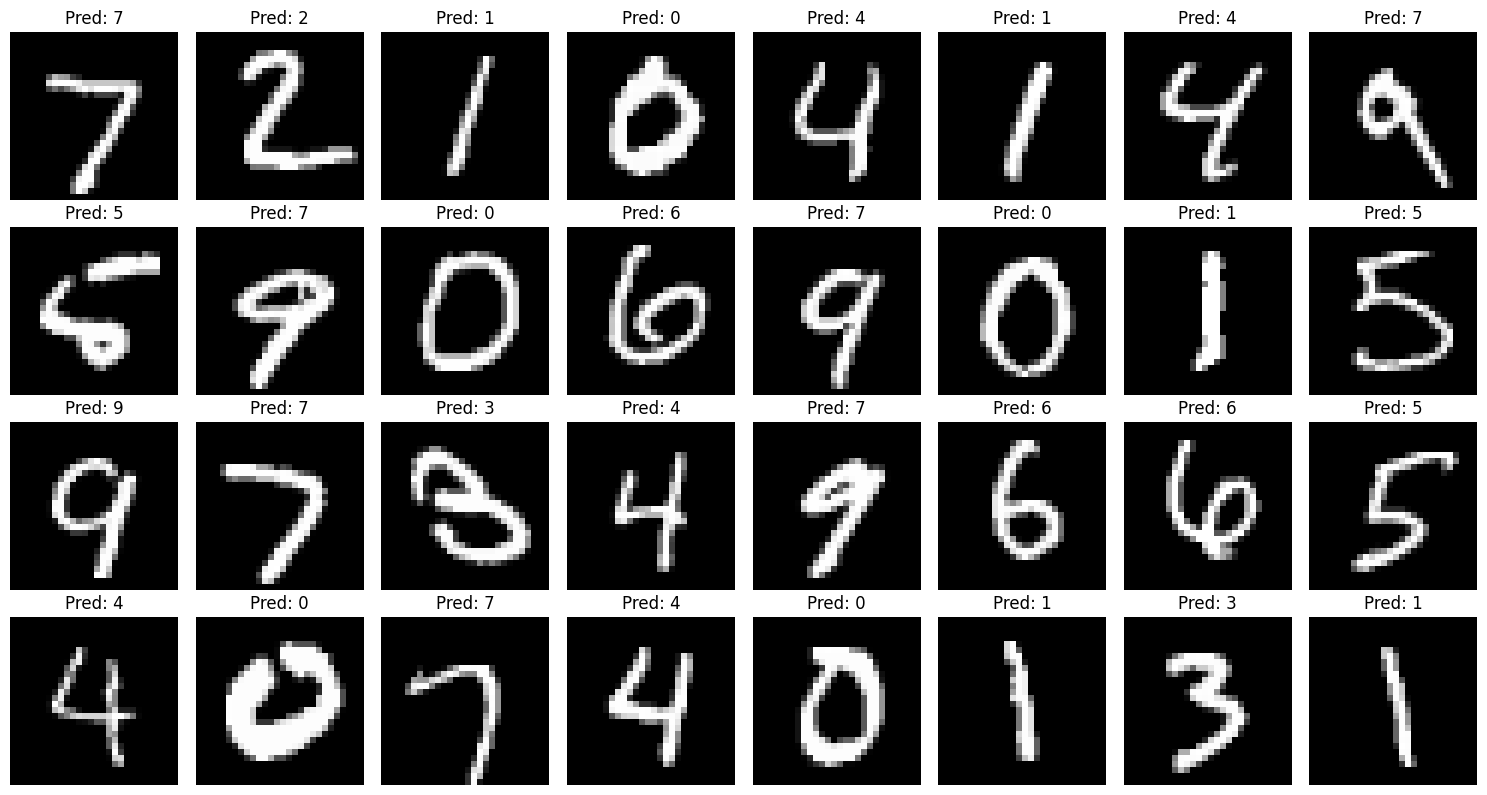

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize the output of the Posit quantized LeNet
def visualize_lenet_output_posit(model, dataloader, n_images=32, nsize=8, es=1, cuda=False):
    model.eval()
    images, labels = next(iter(dataloader))  # Get a batch of test images
    if cuda:
        images = images.cuda()

    # Forward pass through the Posit quantized model
    with torch.no_grad():
        outputs = quantized_forward_posit_with_input_quant_lenet5v1(model, images, nsize=nsize, es=es)

    # Get the predicted class for each image
    _, predicted = torch.max(outputs, 1)

    # Plot the images and the model's predictions in a 4x8 grid
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 8))
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    for i in range(n_images):
        ax = axes[i]
        img = images[i].cpu().numpy().squeeze()  # Move to CPU and remove channel dimension
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pred: {predicted[i].item()}')
        ax.axis('off')

    # Adjust layout so titles and images don't overlap
    plt.tight_layout()
    plt.show()

# Visualize the output of the Posit quantized model in a 4x8 grid
visualize_lenet_output_posit(net_fp32, testloader, n_images=32, nsize=3, es=1, cuda=True)
